## Multi-Step model using TensorFlow

In [1]:
import os
import pandas
import keras
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import IPython
import IPython.display
from keras_tqdm import TQDMNotebookCallback

2023-03-06 13:46:47.572124: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 13:46:48.063835: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-06 13:46:49.136016: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda-11.7/lib64:
2023-03-06 13:46:49.138190: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cann

In [2]:
import tqdm

# quietly deep-reload tqdm
import sys
from IPython.lib import deepreload 

stdout = sys.stdout
sys.stdout = open('junk','w')
deepreload.reload(tqdm)
sys.stdout = stdout

tqdm.__version__

'4.64.1'

In [3]:
print("GPUs Available: ", tf.config.list_physical_devices('GPU'))

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-03-06 13:46:51.045883: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-06 13:46:51.150353: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-06 13:46:51.150578: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [4]:
df = pandas.read_csv("n_sal.csv", index_col=0)
# date_time = pandas.to_datetime(df.pop('Date'), format='%d/%m/%Y %H:%M:%S')
print(df)

         NSAL Hauteur
0                4.68
1                4.64
2                4.61
3                4.57
4                4.54
...               ...
1050187          5.68
1050188          5.70
1050189          5.70
1050190          5.70
1050191          5.71

[990169 rows x 1 columns]


In [5]:
values = df
#values.pop('Source')
#date_time = pandas.to_datetime(values.pop('Date'), format='%d/%m/%Y %H:%M:%S')
#values["Time"] = [(i)*10 for i in range(len(values))]
#values.drop('Source', axis = 1, inplace = True)
#values['Valeur'] = values['Valeur'].transform(lambda x: int(1000*x))
#print(values)

## Données d'entrainements et de validations

In [6]:
n = len(values)
train_df = values[0:int(n*0.7)]
val_df = values[int(n*0.7):int(n*0.9)]
test_df = values[int(n*0.9):]

num_features = df.shape[1]
#print(num_features)

#print(f"Train : {train_df}")
#print(f"Validation : {val_df}")
#print(f"Test : {test_df}")

## Fenêtrage des données

In [254]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        #print(features.shape)
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        #print(inputs.shape)
        #print(type(inputs))

        return inputs, labels
    
    def plot(self, model=None, plot_cols=None, max_subplots=3, figname = None, history = None, test = None):
        if plot_cols == None:
            plot_cols = self.label_columns
        print(f"Plot_cols : {plot_cols}")
        

        inputs, labels = self.example

        fig = plt.figure(figsize=(12*len(inputs),3.5*(len(plot_cols)+1)))

        #print(len(inputs))
        #print(f"inputs : {inputs[0, :, 2]}")
        #print(f"labels : {labels}")
        sub = 1
        max_n = min(max_subplots, len(inputs))
        for plot_col in plot_cols:
            
            plot_col_index = self.column_indices[plot_col]
            #print(self.column_indices)

            for n in range(max_n):
                
                plt.subplot(len(plot_cols)+1, max_n, sub+n)
                plt.ylabel(f'{plot_col}')
                plt.plot([i for i in range(-self.input_width,0)], inputs[n, :, plot_col_index],
                        label='Inputs', marker='.', zorder=-10)

                if self.label_columns:
                    label_col_index = self.label_columns_indices.get(plot_col, None)
                else:
                    label_col_index = plot_col_index

                if label_col_index is None:
                    continue
                #last = inputs[n, :, time_index][-1]

                plt.scatter([i for i in range(self.label_width)], labels[n, :, label_col_index],
                            edgecolors='k', label='Labels', c='#2ca02c', s=64)
                if model is not None:
                    predictions = model(inputs)
                    plt.scatter([i for i in range(self.label_width)],predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)

                if n == 0 and sub == 1:
                    #handles, labels = plt.get_legend_handles_labels()
                    # fig.legend(handles, labels, loc='upper center')
                    
                    if figname != None:
                        font = {'family': 'serif',
                        'weight': 'bold',
                        'size': 16,
                        }
                        fig.suptitle(figname, fontproperties = font)
                    plt.legend( title = "Legend :", facecolor="0.90", edgecolor="black")

            sub+=max_n
            plt.xlabel('Time of Measure')
        
        # Addind a box with loss parameters:
        
        
        if model != None:
            
            ax = plt.subplot(len(plot_cols)+1, max_n, sub+max_n-1)
            
            textobjs = []
            
            dh = 0.35
            h = 0.65
            
            text = ax.text(0.05,h, 
                           f"Training : \n--------------\nLoss (MSE) : {history.history['loss'][-1] : .3f}\nMAE : {history.history['mean_absolute_error'][-1]: .3f}", 
                           ha="left", transform=ax.transAxes, fontsize = 12)
        
            textobjs.append(text)
            
            text = ax.text(0.30,h, 
                           f"Validation : \n--------------\nLoss (MSE) : {history.history['val_loss'][-1]: .3f}\nMAE : {history.history['val_mean_absolute_error'][-1]: .3f}",
                           ha="left", transform=ax.transAxes, fontsize = 12)
        
            textobjs.append(text)
            
            text = ax.text(0.60,h, 
                           f"Test : \n--------------\nLoss (MSE) : {test[0]: .3f}\nMAE : {test[1]: .3f}",
                           ha="left", transform=ax.transAxes, fontsize = 12)
        
            textobjs.append(text)
            
            #t = ax.text(0.4,0.6, 'Hello world line 1', ha='center', color='red', weight='bold', transform=ax.transAxes)
            

            fig.canvas.draw()

            xmin = min([t.get_window_extent().xmin for t in textobjs])*0.85
            xmax = max([t.get_window_extent().xmax for t in textobjs])*1.15
            ymin = min([t.get_window_extent().ymin for t in textobjs])*0.85
            ymax = max([t.get_window_extent().ymax for t in textobjs])*1.15

            xmin, ymin = fig.transFigure.inverted().transform((xmin, ymin))
            xmax, ymax = fig.transFigure.inverted().transform((xmax, ymax))
            
            size = fig.get_size_inches()*fig.dpi

            rect = patches.Rectangle((0,ymin),size[0],ymax-ymin, facecolor='grey', alpha=0.2, transform=fig.transFigure)

            ax.add_patch(rect)

            ax.axis('off')
        
        # Saving the figure
        if figname != None:
            if not os.path.exists("img"):
                 os.makedirs("img")
            fig.savefig("img/" + figname + ".png", bbox_inches='tight')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        #print(data.shape)
        ds = tf.keras.utils.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=512,)

        ds = ds.map(self.split_window)

        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

In [47]:
w2 = WindowGenerator(input_width=100, label_width=2, shift=1, train_df=train_df, val_df=val_df, test_df=test_df, 
                     label_columns=["NSAL Hauteur"])
w2.label_columns

['NSAL Hauteur']

In [48]:
example_window = tf.stack([
                               np.array(train_df[100:100+w2.total_window_size]),
                           ])
print(train_df[:w2.total_window_size].shape)
example_inputs, example_labels = w2.split_window(example_window)
w2._example = example_inputs, example_labels

(101, 1)


Plot_cols : ['NSAL Hauteur']


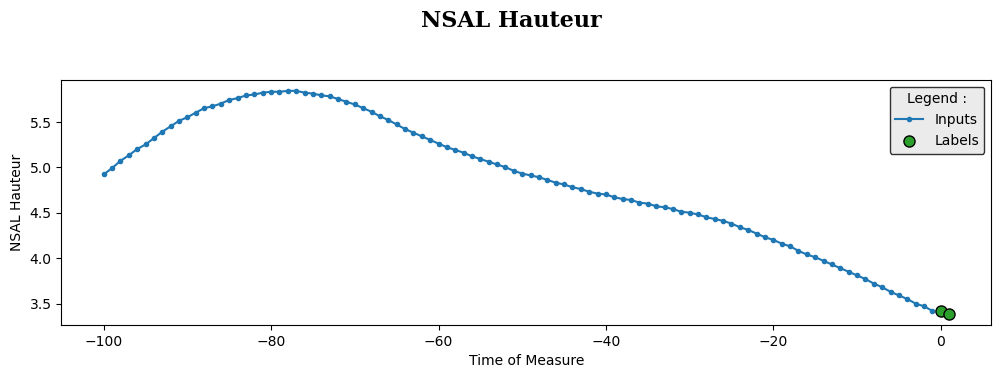

In [49]:
w2.plot(figname="NSAL Hauteur")

### Modèle en une seule étape

In [41]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Valeur'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Valeur']

### Baseline

In [42]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [46]:
baseline = Baseline(label_index=0)

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

baseline.fit(single_step_window.train, epochs = 10, steps_per_epoch = 20)

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

Epoch 1/10
20/20 [==============================] - 1s 2ms/step - loss: 0.0182 - mean_absolute_error: 0.1181
Epoch 2/10
20/20 [==============================] - 0s 2ms/step - loss: 0.0189 - mean_absolute_error: 0.1197
Epoch 3/10
20/20 [==============================] - 0s 4ms/step - loss: 0.0190 - mean_absolute_error: 0.1220
Epoch 4/10
20/20 [==============================] - 0s 3ms/step - loss: 0.0190 - mean_absolute_error: 0.1206
Epoch 5/10
20/20 [==============================] - 0s 3ms/step - loss: 0.0187 - mean_absolute_error: 0.1214
Epoch 6/10
20/20 [==============================] - 0s 2ms/step - loss: 0.0185 - mean_absolute_error: 0.1196
Epoch 7/10
20/20 [==============================] - 0s 3ms/step - loss: 0.0190 - mean_absolute_error: 0.1200
Epoch 8/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0201 - mean_absolute_error: 0.1249
Epoch 9/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0189 - mean_absolute_error: 0.1205
Epoch 10/10
2115/21

### Modèle mutli-étapes

Plot_cols : ['NSAL Hauteur']


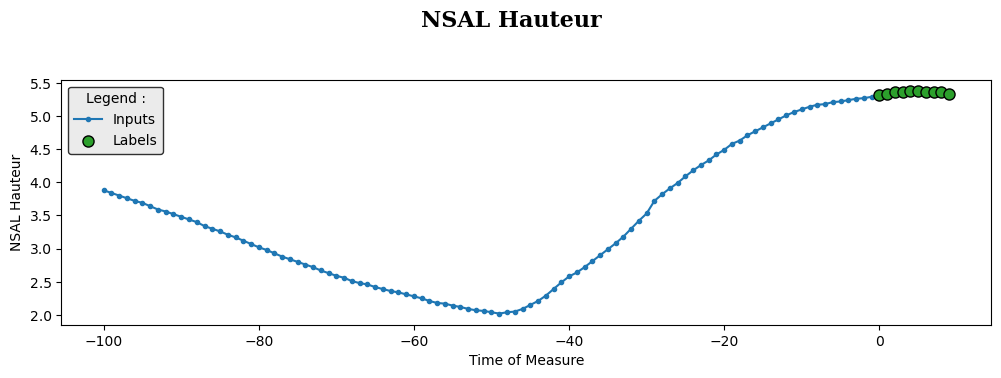

In [255]:
OUT_STEPS = 10
multi_window = WindowGenerator(input_width=100,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=["NSAL Hauteur"])

example_window = tf.stack([np.array(test_df[:multi_window.total_window_size])])

example_inputs, example_labels = multi_window.split_window(example_window)
multi_window._example = example_inputs, example_labels
#print(example_inputs)

multi_window.plot(figname="NSAL Hauteur")

### Compile and fit

In [256]:
MAX_EPOCHS = 1
tqdm_callback = tfa.callbacks.TQDMProgressBar()
def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=5,
                                                    mode='min')
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=1e-6)
    
    tqdm_callback = tfa.callbacks.TQDMProgressBar()

    model.compile(loss="mean_squared_error",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=["mean_absolute_error"])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val, verbose = 0,
                      callbacks=[reduce_lr, early_stopping, tqdm_callback])
    return history

In [257]:
multi_val_performance = {}
multi_performance = {}

### Linéaire

In [258]:
multi_linear_model = keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

print("Evaluate Validation set")
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val, callbacks=[tqdm_callback], verbose=0)
print("Evaluate Validation set")

linear_test = multi_linear_model.evaluate(multi_window.test, callbacks=[tqdm_callback] , verbose=0)

multi_performance['Linear'] = linear_test

Training:   0%|                                                                                  0/1 ETA: ?s, …

Epoch 1/1


0/1354                                                                                                        …

Evaluate Validation set


0/387                                                                                               ETA: ?s - …

Evaluate Validation set


0/194                                                                                               ETA: ?s - …

In [235]:
multi_performance

{'Linear': [0.36311277747154236, 0.5001875758171082]}

In [18]:
history.history

{'loss': [6.936054706573486],
 'mean_absolute_error': [1.830396056175232],
 'val_loss': [2.498063087463379],
 'val_mean_absolute_error': [0.5278813242912292],
 'lr': [0.001]}

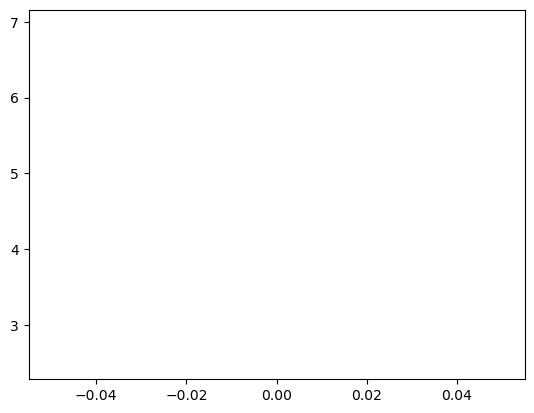

In [199]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

Plot_cols : ['NSAL Hauteur']


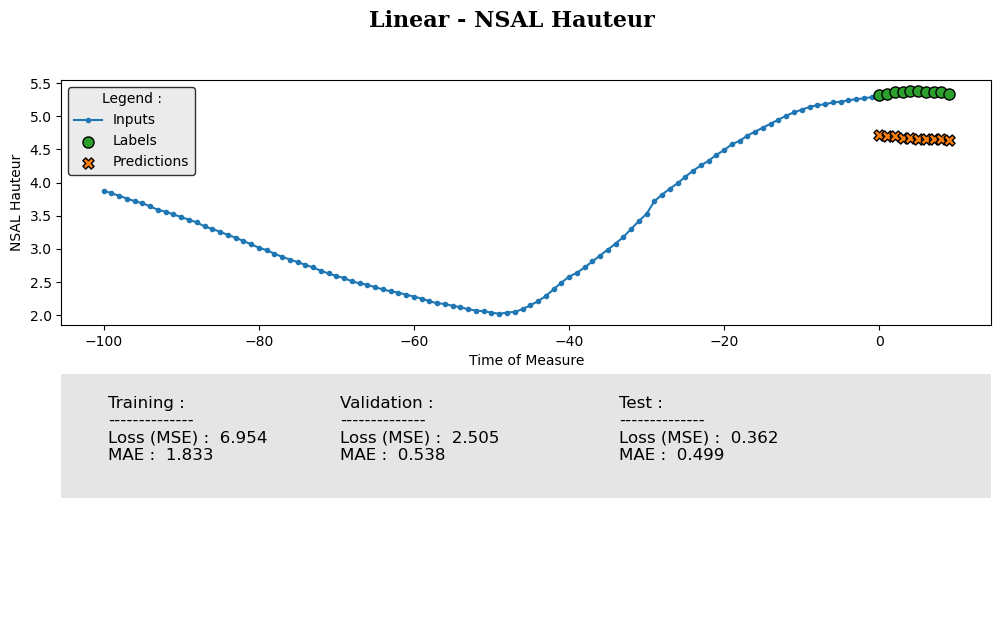

In [259]:
multi_window.plot(multi_linear_model, figname="Linear - NSAL Hauteur", history = history, test = linear_test)

### Dense

In [24]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(128, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

print("Evaluate Validation set")
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val, callbacks=[tqdm_callback], verbose=0)
print("Evaluate Test set")
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, callbacks=[tqdm_callback], verbose=0)

Training:   0%|                                                                                 0/50 ETA: ?s, …

Epoch 1/50


0/1354                                                                                                        …

Epoch 2/50


0/1354                                                                                                        …

Epoch 3/50


0/1354                                                                                                        …

Epoch 4/50


0/1354                                                                                                        …

Epoch 5/50


0/1354                                                                                                        …

Epoch 6/50


0/1354                                                                                                        …

Epoch 7/50


0/1354                                                                                                        …

Epoch 8/50


0/1354                                                                                                        …

Epoch 9/50


0/1354                                                                                                        …

Epoch 10/50


0/1354                                                                                                        …

Epoch 11/50


0/1354                                                                                                        …

Epoch 12/50


0/1354                                                                                                        …

Epoch 13/50


0/1354                                                                                                        …

Evaluate Validation set


0/387                                                                                               ETA: ?s - …

Evaluate Test set


0/194                                                                                               ETA: ?s - …

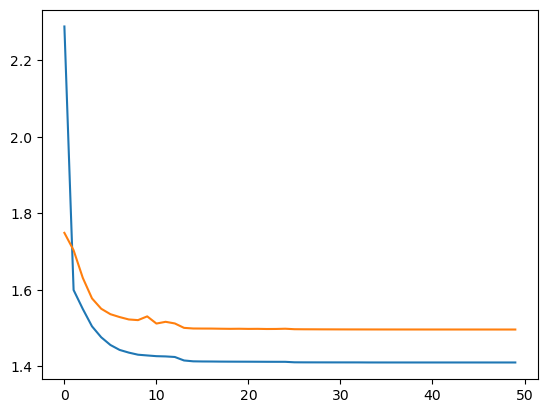

In [28]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

Plot_cols : ['NSAL Hauteur']


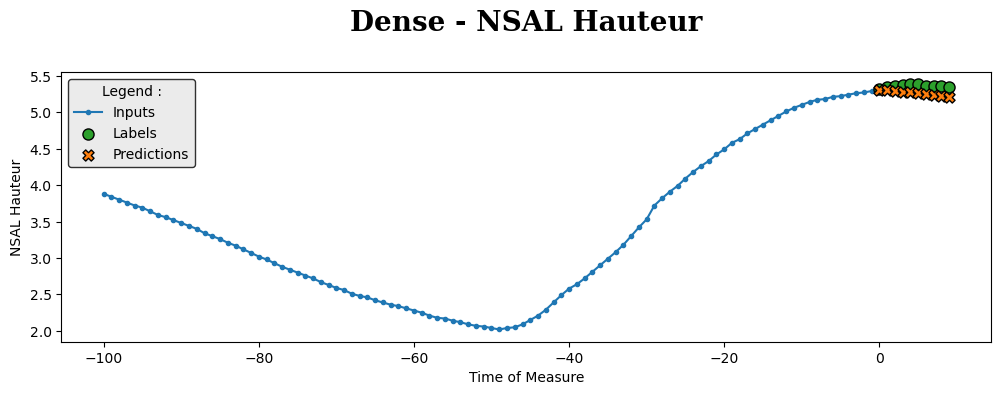

In [26]:
multi_window.plot(multi_dense_model, figname="Dense - NSAL Hauteur")

### CNN

In [27]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -3:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(64, activation='relu', kernel_size=(3)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

print("Evaluate Validation set")
multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val, callbacks=[tqdm_callback], verbose=0)
print("Evaluate Test set")
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, callbacks=[tqdm_callback], verbose=0)

Training:   0%|                                                                                 0/50 ETA: ?s, …

Epoch 1/50


0/1354                                                                                                        …

Epoch 2/50


0/1354                                                                                                        …

Epoch 3/50


0/1354                                                                                                        …

Epoch 4/50


0/1354                                                                                                        …

Epoch 5/50


0/1354                                                                                                        …

Epoch 6/50


0/1354                                                                                                        …

Epoch 7/50


0/1354                                                                                                        …

Epoch 8/50


0/1354                                                                                                        …

Epoch 9/50


0/1354                                                                                                        …

Epoch 10/50


0/1354                                                                                                        …

Epoch 11/50


0/1354                                                                                                        …

Epoch 12/50


0/1354                                                                                                        …

Epoch 13/50


0/1354                                                                                                        …

Epoch 14/50


0/1354                                                                                                        …

Epoch 15/50


0/1354                                                                                                        …

Epoch 16/50


0/1354                                                                                                        …

Epoch 17/50


0/1354                                                                                                        …

Epoch 18/50


0/1354                                                                                                        …

Epoch 19/50


0/1354                                                                                                        …

Epoch 20/50


0/1354                                                                                                        …

Epoch 21/50


0/1354                                                                                                        …

Epoch 22/50


0/1354                                                                                                        …

Epoch 23/50


0/1354                                                                                                        …

Epoch 24/50


0/1354                                                                                                        …

Epoch 25/50


0/1354                                                                                                        …

Epoch 26/50


0/1354                                                                                                        …

Epoch 27/50


0/1354                                                                                                        …

Epoch 28/50


0/1354                                                                                                        …

Epoch 29/50


0/1354                                                                                                        …

Epoch 30/50


0/1354                                                                                                        …

Epoch 31/50


0/1354                                                                                                        …

Epoch 32/50


0/1354                                                                                                        …

Epoch 33/50


0/1354                                                                                                        …

Epoch 34/50


0/1354                                                                                                        …

Epoch 35/50


0/1354                                                                                                        …

Epoch 36/50


0/1354                                                                                                        …

Epoch 37/50


0/1354                                                                                                        …

Epoch 38/50


0/1354                                                                                                        …

Epoch 39/50


0/1354                                                                                                        …

Epoch 40/50


0/1354                                                                                                        …

Epoch 41/50


0/1354                                                                                                        …

Epoch 42/50


0/1354                                                                                                        …

Epoch 43/50


0/1354                                                                                                        …

Epoch 44/50


0/1354                                                                                                        …

Epoch 45/50


0/1354                                                                                                        …

Epoch 46/50


0/1354                                                                                                        …

Epoch 47/50


0/1354                                                                                                        …

Epoch 48/50


0/1354                                                                                                        …

Epoch 49/50


0/1354                                                                                                        …

Epoch 50/50


0/1354                                                                                                        …

Evaluate Validation set


0/387                                                                                               ETA: ?s - …

Evaluate Test set


0/194                                                                                               ETA: ?s - …

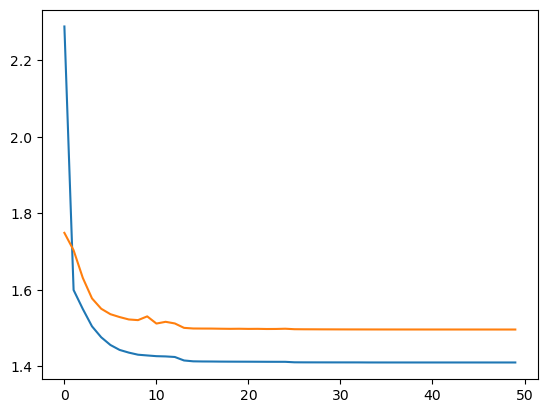

In [29]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

Plot_cols : ['NSAL Hauteur']


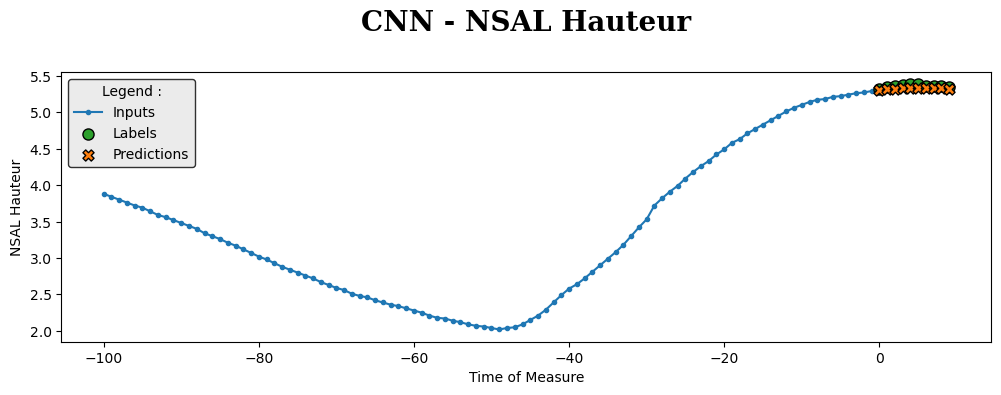

In [30]:
multi_window.plot(multi_conv_model, figname = "CNN - NSAL Hauteur")

In [12]:
multi_conv_model.save("models/MultiCNN")

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7facccfa6320>, 140380149621232), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7faccc6307c0>, 140380149621312), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7faccc6324a0>, 140380149623232), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7faccc604910>, 140380149622592), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 2, 128),

INFO:tensorflow:Assets written to: models/MultiCNN/assets


INFO:tensorflow:Assets written to: models/MultiCNN/assets


### RNN

In [31]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(64, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

print("Evaluate Validation set")
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val, callbacks=[tqdm_callback], verbose=0)
print("Evaluate Test set")
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, callbacks=[tqdm_callback], verbose=0)

Training:   0%|                                                                                 0/50 ETA: ?s, …

Epoch 1/50


0/1354                                                                                                        …

Epoch 2/50


0/1354                                                                                                        …

Epoch 3/50


0/1354                                                                                                        …

Epoch 4/50


0/1354                                                                                                        …

Epoch 5/50


0/1354                                                                                                        …

Epoch 6/50


0/1354                                                                                                        …

Epoch 7/50


0/1354                                                                                                        …

Epoch 8/50


0/1354                                                                                                        …

Epoch 9/50


0/1354                                                                                                        …

Epoch 10/50


0/1354                                                                                                        …

Epoch 11/50


0/1354                                                                                                        …

Epoch 12/50


0/1354                                                                                                        …

Epoch 13/50


0/1354                                                                                                        …

Epoch 14/50


0/1354                                                                                                        …

Epoch 15/50


0/1354                                                                                                        …

Epoch 16/50


0/1354                                                                                                        …

Epoch 17/50


0/1354                                                                                                        …

Epoch 18/50


0/1354                                                                                                        …

Evaluate Validation set


0/387                                                                                               ETA: ?s - …

Evaluate Test set


0/194                                                                                               ETA: ?s - …

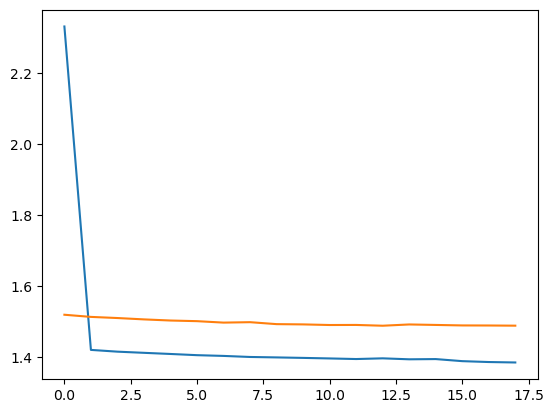

In [32]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

Plot_cols : ['NSAL Hauteur']


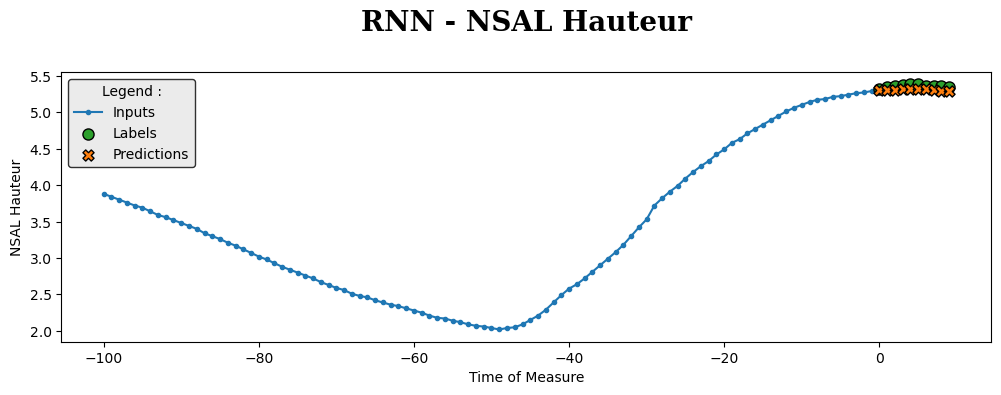

In [33]:
multi_window.plot(multi_lstm_model, figname="RNN - NSAL Hauteur")

In [ ]:
multi_lstm_model.save('models/multi_lstm_model.h5')

['loss', 'mean_absolute_error']


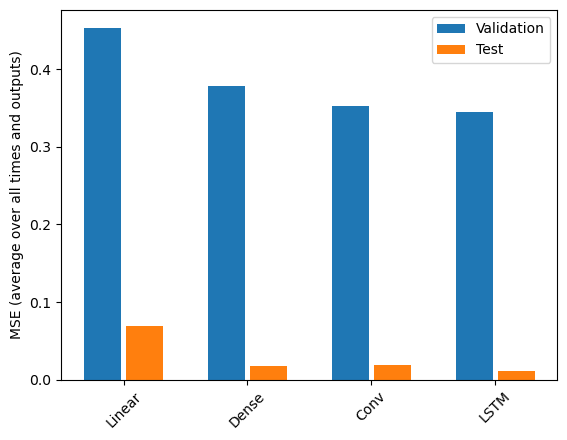

In [54]:
x = np.arange(len(multi_performance))
width = 0.3

print(multi_dense_model.metrics_names)

metric_name = 'mean_squared_error'
metric_index = multi_dense_model.metrics_names.index('loss')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MSE (average over all times and outputs)')
_ = plt.legend()

### RNN Auto-régréssif

In [16]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)
        
    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.lstm_rnn(inputs)

        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state
    
    def call(self, inputs, training=None):
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        # Initialize the LSTM state.
        prediction, state = self.warmup(inputs)

        # Insert the first prediction.
        predictions.append(prediction)

        # Run the rest of the prediction steps.
        for n in range(1, self.out_steps):
            # Use the last prediction as input.
            x = prediction
            # Execute one lstm step.
            x, state = self.lstm_cell(x, states=state,
                                      training=training)
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output.
            predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions

In [17]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [18]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([3, 2])

In [21]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

2111/2111 [==============================] - 23s 11ms/step - loss: 0.0079 - mean_absolute_error: 0.0503


NameError: name 'multi_val_performance' is not defined

### RNN Perso

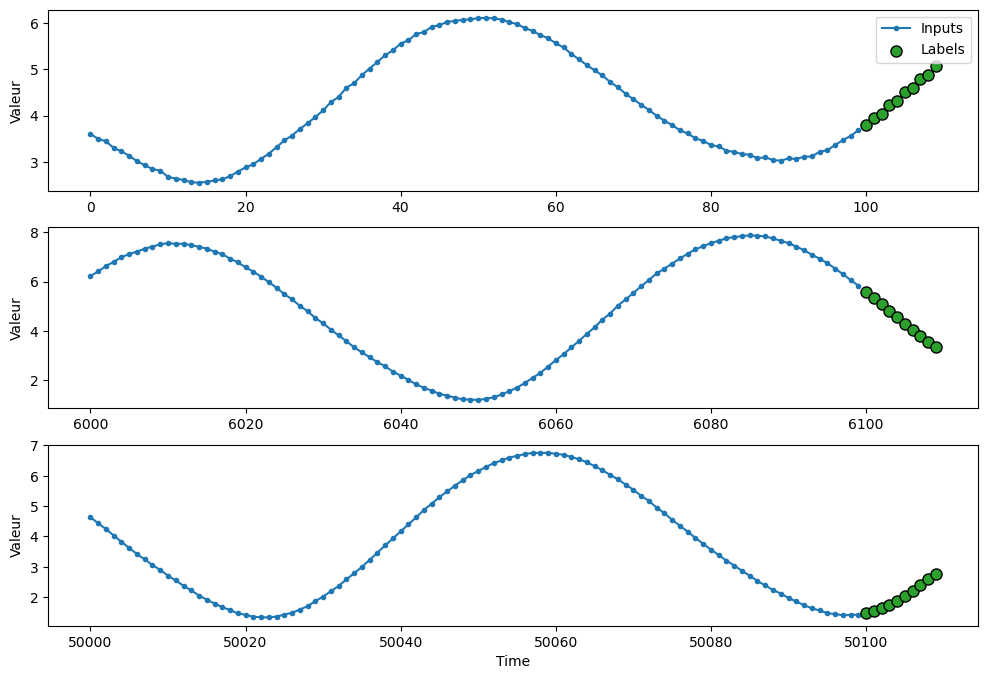

In [24]:
OUT_STEPS = 10
multi_window = WindowGenerator(input_width=100,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

example_window = tf.stack([np.array(train_df[:multi_window.total_window_size]),
                           np.array(train_df[6000:6000+multi_window.total_window_size]),
                           np.array(train_df[50000:50000+multi_window.total_window_size])])

example_inputs, example_labels = multi_window.split_window(example_window)
multi_window._example = example_inputs, example_labels

multi_window.plot()

In [227]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(OUT_STEPS*num_features),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])])
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
history = model.fit(
    multi_window.train,
    epochs=5,
    validation_data=multi_window.val,
    validation_steps=3
)

Epoch 1/5
   2/7396 [..............................] - ETA: 8:17 - loss: 19.9042   

model.evaluate(multi_window.test)
multi_window.plot(model)

In [31]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                            df: 15.1 MiB
                        values: 15.1 MiB
                      train_df: 10.6 MiB
                        val_df:  3.0 MiB
                       test_df:  1.5 MiB
                           _ii:  4.9 KiB
                          _i29:  4.9 KiB
                          _i22:  4.8 KiB
                          _i13:  4.8 KiB
                           _i7:  4.8 KiB
